In [1]:
import sys, os
import math, random
import numpy as np
import pandas as pd
import operator

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import dijkstra

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.lines  as ml
%matplotlib inline

In [2]:
palette = [
    "#000000", "#0019ff", "#0080ff",
    "#00e5ff", "#00ff4d", "#19fe00",
    "#80ff00", "#e6ff00", "#ffff00",
    "#ffe53c", "#ffdb77", "#ffe0b2",
]
n = len(palette)

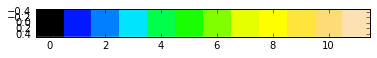

In [3]:
cmap = mc.ListedColormap(palette, 'indexed')
im = plt.imshow([range(n)], interpolation='none', cmap=cmap)
plt.show()

In [4]:
class Raster(np.ndarray):
    def __new__(cls, input_array, cellsize, xllcorner, yllcorner):
        obj = np.asarray(input_array).view(cls)
        obj.cellsize  = cellsize
        obj.xllcorner = xllcorner
        obj.yllcorner = yllcorner
        
        # 1-D list of the raster's values 
        v = obj.flatten()
        obj.values = v[~np.isnan(v)]
        
        return obj
    
    @classmethod
    def load(cls, filename):
        data  = [ ]
        attrs = { }
        with open(filename) as f:
            for i in range(6):
                key,value = next(f).strip().split()
                attrs[key] = value
            NODATA_value = attrs.get("NODATA_value", "-9999")
        
            for line in f:
                row = list(map(lambda x: np.nan if x == NODATA_value else float(x), line.split()))
                row = [ x if x < 1e3 else np.nan for x in row ]
                if row:
                    data.append(row)

        return Raster(np.asarray(data), float(attrs["cellsize"])
                                      , float(attrs["xllcorner"])
                                      , float(attrs["yllcorner"]))


In [5]:
%%time
I = Raster.load("../bb450_final.asc")

CPU times: user 4.12 s, sys: 260 ms, total: 4.38 s
Wall time: 4.48 s


In [6]:
%%time
R = Raster.load("../../BB450/bb_resist450.asc")

CPU times: user 4.08 s, sys: 218 ms, total: 4.3 s
Wall time: 4.39 s


In [7]:
nodes = Raster.load("../../BB450/bb_nodes450.asc")
nodes = np.argwhere(~np.isnan(nodes))+1  # only care about the indicies
len(nodes)

245

In [8]:
lo    = float(np.min(I.values))
hi    = float(np.max(I.values))
mu    = float(np.mean(I.values))
sigma = float(np.std(I.values))

In [9]:
print("""
Size:       {} x {}
Cell size:  {}
No. Cells:  {}
Min Value:  {}
Max Value:  {}
Mean Value: {}
Std Dev:    {}
Colors:     {}
""".format(I.shape[0], I.shape[1], I.cellsize, len(I.values), lo, hi, mu, sigma, n))


Size:       2845 x 2483
Cell size:  450.0
No. Cells:  2806114
Min Value:  0.0
Max Value:  7.128635
Mean Value: 0.13578042048469882
Std Dev:    0.08593180316938359
Colors:     12



53.9351462406472 1500.0933304298103


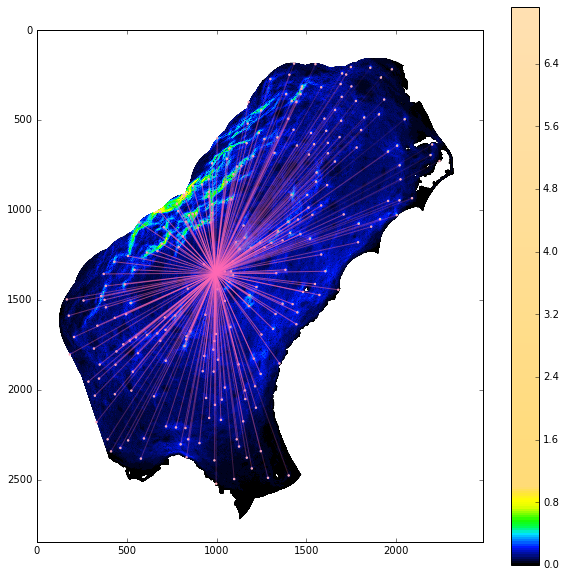

In [10]:
divs = [0.] + [ (i*sigma+mu)/hi for i in range(1,n-1) ] + [1.]
cmap = mc.LinearSegmentedColormap.from_list("", list(zip(divs, palette)))
fig = plt.figure(figsize=(10,10))
img = plt.imshow(I, origin="upper", cmap=cmap)
cy,cx = nodes[135]
maxdist = 0
mindist = 1e9
for y,x in nodes:
    dist = math.hypot(cx - x, cy - y)
    if dist > 0:
        maxdist = max(maxdist, dist)
        mindist = min(mindist, dist)
print(mindist,maxdist)
for y,x in nodes:
    dist = math.hypot(cx - x, cy - y)
    dist = (dist - mindist) / (maxdist - mindist)  # dist is [0,1]
    alpha = (0.8 * (1. - dist)) + 0.05  # map maxdist to 0.1 and mindist to .9
    l = ml.Line2D([cx,x], [cy,y], color="#FF69B4", alpha=alpha)
    img.axes.add_artist(l)
for y,x in nodes:
    img.axes.add_artist(plt.Circle((x,y), 4, color='#FFB6C1'))
#img.axes.add_artist(plt.Circle((cx,cy), 14, color='r'))
fig.colorbar(img)

In [11]:
N = len(I.values)
print("N = {:,}\nsqr(N) = {:,}\n9N = {:,}".format(N, N**2, 9*N))

N = 2,806,114
sqr(N) = 7,874,275,780,996
9N = 25,255,026


In [12]:
%%time
indices = { (int(x),int(y)):index for index,(x,y) in enumerate(np.argwhere(~np.isnan(I))) }
print(len(indices))

2806114
CPU times: user 5.5 s, sys: 406 ms, total: 5.91 s
Wall time: 5.99 s


In [13]:
%%time
coordinates = [ (int(x),int(y)) for (x,y) in np.argwhere(~np.isnan(I)) ]

CPU times: user 4.61 s, sys: 233 ms, total: 4.84 s
Wall time: 4.9 s


In [14]:
list(indices.items())[0]

((588, 1914), 374264)

In [15]:
coordinates[374264]

(588, 1914)

In [16]:
G1 = lil_matrix((N, N))
for (i,j),id1 in tqdm(indices.items()):
    try:
        id2 = indices[i+1,j]
        value = (R[i,j] + R[i+1,j]) / 2.
        G1[id1,id2] = value
        G1[id2,id1] = value
    except KeyError:
        pass
    try:
        id2 = indices[i,j+1]
        value = (R[i,j] + R[i,j+1]) / 2.
        G1[id1,id2] = value
        G1[id2,id1] = value
    except KeyError:
        pass

G1

100%|██████████| 2806114/2806114 [01:27<00:00, 32093.37it/s]


<2806114x2806114 sparse matrix of type '<class 'numpy.float64'>'
	with 11211754 stored elements in LInked List format>

In [17]:
%%time
G = csr_matrix(G1)

CPU times: user 8.99 s, sys: 361 ms, total: 9.35 s
Wall time: 9.47 s


In [18]:
G

<2806114x2806114 sparse matrix of type '<class 'numpy.float64'>'
	with 11211754 stored elements in Compressed Sparse Row format>

In [19]:
nindices = [ indices[(y,x)] for y,x in nodes ]

In [20]:
%%time
dist_matrix,predecessors = dijkstra(G, directed=False, return_predecessors=True, indices=nindices)

CPU times: user 14min 30s, sys: 29 s, total: 14min 59s
Wall time: 15min 46s


In [25]:
def plot_paths(origin):
    lines  = [ ]
    for index,start in enumerate(nindices):
        if index == origin:
            continue
        i = start
        lines.append((dist_matrix[origin][i], [ ], [ ]))
        while i != -9999:
            lines[-1][1].append(coordinates[i][1])
            lines[-1][2].append(coordinates[i][0])
            i = predecessors[origin][i]

    rmin = min(map(operator.itemgetter(0), lines))
    rmax = max(map(operator.itemgetter(0), lines))
    
    divs = [0.] + [ (i*sigma+mu)/hi for i in range(1,n-1) ] + [1.]
    cmap = mc.LinearSegmentedColormap.from_list("", list(zip(divs, palette)))
    fig = plt.figure(figsize=(10,10))
    img = plt.imshow(I, origin="upper", cmap=cmap)

    for rdist,xs,ys in lines:
        alpha = (0.5 * (1. - (rdist - rmin) / (rmax - rmin))) + 0.1  # map maxdist to 0.1 and mindist to .6
        l = ml.Line2D(xs, ys, color="#FF69B4", alpha=alpha)
        img.axes.add_artist(l)

    for y,x in nodes:
        img.axes.add_artist(plt.Circle((x,y), 6, color='#FFB6C1'))

    return fig.colorbar(img)

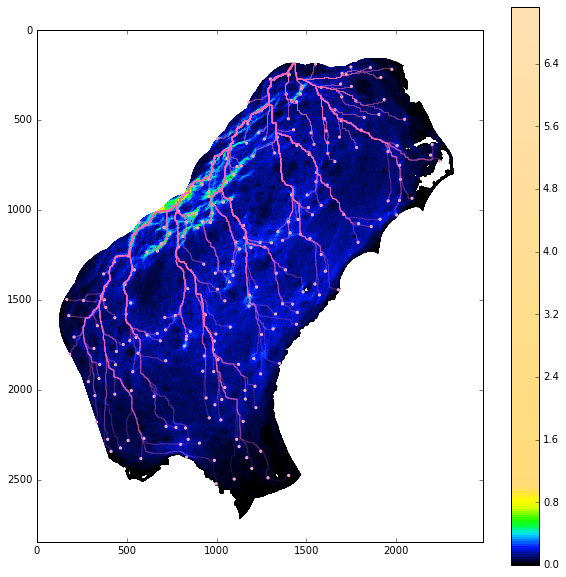

In [26]:
plot_paths(0)

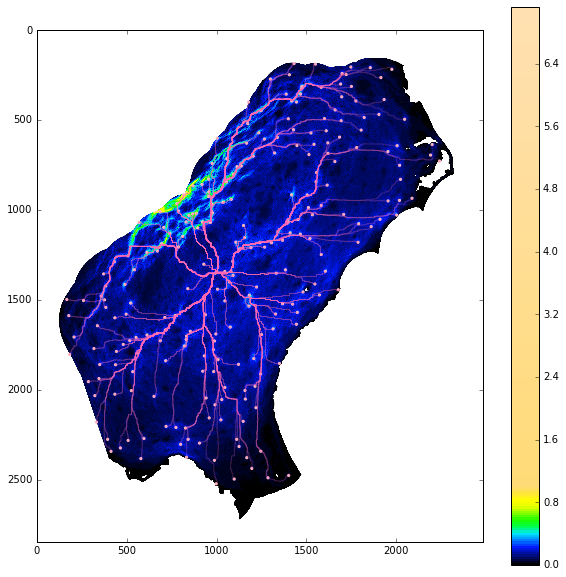

In [27]:
plot_paths(135)

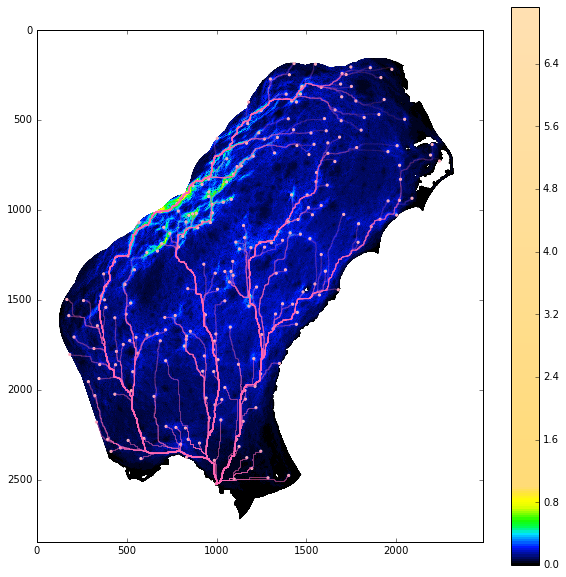

In [28]:
plot_paths(244)